                 customer_id   loyalty  Products number  USD_total  \
customer_id         1.000000 -0.310460        -0.304621  -0.316912   
loyalty            -0.310460  1.000000         0.822648   0.886115   
Products number    -0.304621  0.822648         1.000000   0.966291   
USD_total          -0.316912  0.886115         0.966291   1.000000   
Renew loyalty      -0.301074  0.591191         0.762205   0.722974   
Sale part           0.005528  0.120246         0.101911   0.102894   
GDP                -0.114365  0.174227         0.188373   0.171175   
HDI                -0.135725  0.114480         0.105547   0.101266   
population         -0.074393  0.132011         0.149863   0.129140   
urban              -0.085678  0.121771         0.202018   0.192311   
avg_income         -0.148738  0.097542         0.102672   0.095078   

                 Renew loyalty  Sale part       GDP       HDI  population  \
customer_id          -0.301074   0.005528 -0.114365 -0.135725   -0.074393   
loyal

/home/semionn/anaconda2/lib/python2.7/site-packages/matplotlib/lines.py:1106: UnicodeWarning: Unicode unequal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if self._markerfacecolor != fc:


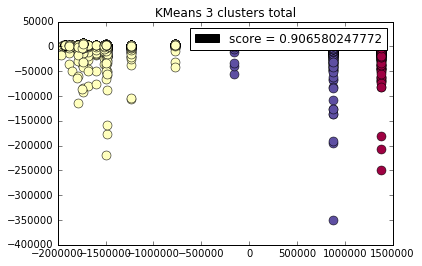

In [1]:
%matplotlib inline

from sklearn.linear_model.base import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing.data import StandardScaler, PolynomialFeatures
from sklearn.svm import OneClassSVM
from sklearn.cross_validation import cross_val_predict
from sklearn import cross_validation
from sklearn import tree
from sklearn import metrics
from sklearn import ensemble
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm.classes import SVR

import data_preprocess
import metadata
import logging
from clusterization_model import ClusterizationModel
from sklearn import preprocessing as preproc

np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

# reload(logging)
logging.basicConfig(format='%(levelname)s %(asctime)s %(message)s', datefmt='%Y-%m-%d %H:%M:%S', level=logging.DEBUG)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)


def remove_columns(df, columns):
    new_columns = list(filter(lambda x: x not in columns, df.columns))
    return df[new_columns]


def get_columns(df, columns, get_all_match=True):
    new_columns = []
    for column in columns:
        all_match = list(filter(lambda x: column in x, df.columns))
        if get_all_match or column not in df.columns:
            new_columns += all_match
        else:
            new_columns.append(column)
    return new_columns


def plot_statistic(statistic, title, names=None, conf_interv=None):
    fig, ax = plt.subplots()
    index = np.arange(len(statistic))
    plt.bar(index, statistic, yerr=conf_interv, color='b', alpha=0.7)
    if names is not None:
        plt.xticks(index + 0.4, names)
    # plt.xlabel("Stocks")
    plt.ylabel(title)
    plt.show()


data = data_preprocess.get_data()

X = data.main_data_frame


def remove_outliers(data):
    clf = OneClassSVM(nu=0.2, kernel="rbf", gamma=0.00001)
    clf.fit(data)
    logging.info("%s outliers removed from %s elements" % ((clf.predict(data) == -1).sum(), len(data)))
    return data[clf.predict(data) == 1]


def clients_clusterization(X):
    clients_df = X[get_columns(X, ['stock_id', 'customer_id', 'quantity', 'customer_status', 'license_type', 'iso',
                                   'amount_in_usd', 'GDP', 'HDI', 'population', 'urban', 'avg_income',
                                   'discount_perc'])]
    clients_df.reset_index(inplace=True)

    clients_loyalty = clients_df.groupby('customer_id')[['customer_id']].mean()
    clients_loyalty['loyalty'] = 0
    clients_loyalty['Renew loyalty'] = 0
    del clients_loyalty['customer_id']
    stock_quantity_columns = []
    for stock_id in metadata.stock_ids:
        stock_name = metadata.stock_ids[stock_id][0]
        if stock_name == "None":
            continue
        add_N = clients_df[clients_df['stock_id'] == stock_id].groupby('customer_id')['quantity'].sum()
        add_Renew = clients_df[(clients_df['stock_id'] == stock_id) &
                               (clients_df['license_type'] == 2)].groupby('customer_id')['quantity'].count()
        if len(add_N) == 0:
            continue
        col_name = stock_name + '_quantity'
        stock_quantity_columns.append(col_name)
        add_N_df = add_N.to_frame(col_name)
        clients_loyalty = pd.merge(clients_loyalty, add_N_df, how='left', left_index=True, right_index=True)
        clients_loyalty[col_name] = np.nan_to_num(clients_loyalty[col_name])

        add_N2 = add_N * add_N
        add_N2_df = add_N2.to_frame('loyalty')
        add_Renew2 = add_Renew * add_Renew
        add_Renew2_df = add_Renew2.to_frame('Renew loyalty')
        clients_loyalty = pd.merge(clients_loyalty, add_N2_df, how='left', left_index=True, right_index=True)
        clients_loyalty['loyalty'] = clients_loyalty['loyalty_x'] + np.nan_to_num(clients_loyalty['loyalty_y'])
        clients_loyalty = pd.merge(clients_loyalty, add_Renew2_df, how='left', left_index=True, right_index=True)
        clients_loyalty['Renew loyalty'] = clients_loyalty['Renew loyalty_x'] + np.nan_to_num(
            clients_loyalty['Renew loyalty_y'])
        del clients_loyalty['loyalty_x']
        del clients_loyalty['loyalty_y']
        del clients_loyalty['Renew loyalty_x']
        del clients_loyalty['Renew loyalty_y']

    clients_loyalty['loyalty'] **= 0.5
    clients_loyalty['Renew loyalty'] **= 0.5

    clients_df = pd.merge(clients_df, clients_loyalty, how='left', left_on='customer_id', right_index=True)

    def calc_feature(df_from, df_to, base_param_name, new_param_name, group_id='customer_id'):
        df_from = df_from.groupby(group_id).sum().reset_index()
        df_from[new_param_name] = df_from[base_param_name]
        result = pd.merge(df_to, df_from[[group_id, new_param_name]], how='left', on=group_id)
        result[new_param_name] = np.nan_to_num(result[new_param_name])
        return result

    clients_new_pursh = clients_df[['customer_id', 'quantity', 'license_type']].loc[clients_df['license_type'] == 0]
    clients_df = calc_feature(clients_new_pursh, clients_df, 'quantity', 'Products number')

    clients_df = calc_feature(clients_df[['customer_id', 'amount_in_usd']], clients_df, 'amount_in_usd', 'USD_total')

    clients_sale_filtered = clients_df[['customer_id', 'amount_in_usd']][clients_df['discount_perc'] > 10]
    clients_df = calc_feature(clients_sale_filtered, clients_df, 'amount_in_usd', 'Dicsount_amount_USD')

    clients_df['Sale part'] = clients_df['Dicsount_amount_USD'] / clients_df['USD_total']

    old_columns = ['GDP', 'HDI', 'population', 'urban', 'avg_income']
    chosen_columns = ['customer_id', 'loyalty', 'Products number', 'USD_total', 'Renew loyalty',
                      'Sale part'] + old_columns  # + stock_quantity_columns
    clients_df = clients_df[chosen_columns]
    print(clients_df.corr())

    clients_df = clients_df.groupby('customer_id').mean().reset_index()
    # drop few outliers, which have been found by hierarchy clusterization
    drop_index = clients_df['customer_id'].apply(
        lambda x: x not in [10402, 10518, 3513, 3795, 5632, 6372, 8325, 1031, 3384,
                            5586, 6308, 8249, 10100, 2857, 5555, 6265, 8183, 10009, 2850, 907, 1006, 37, 904])
    clients_df = clients_df.drop(drop_index)

    columns_without_id = list(clients_df.columns)
    columns_without_id.remove('customer_id')
    clients = clients_df[columns_without_id]

    n_clusters = 3
    # f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
    # clustering_model = ClusterizationModel(model="agglomerative").fit(clients)
    # clustering_model.draw_clusters(method="", axis=ax1, show=False)
    # clustering_model = ClusterizationModel(model="dbscan", eps=5e4, min_samples=1).fit(clients)
    # clustering_model.draw_clusters(method="", axis=ax2, show=False)
    clustering_model = ClusterizationModel(n_clusters=n_clusters, model="KMeans").fit(clients)
    clustering_model.draw_clusters(method="", show=True)
    # clustering_model = ClusterizationModel(model="hierarchy").fit(clients)
    # clustering_model.draw_clusters(method="dendrogram", show=True)

    mean_values = clustering_model.get_mean_values()
    mean_values = mean_values.sort_values(by='loyalty', ascending=[1])

    labels = clustering_model.get_labels()
    clients_df['label'] = pd.Series(labels)
    return mean_values, clients_df


mean_values, clients_df = clients_clusterization(X)

In [2]:
print(mean_values)

         loyalty  Products number    USD_total  Renew loyalty  Sale part  \
label                                                                      
1.0    11.619875         7.820803  4031.300438       0.375189   0.734586   
2.0    14.005250         9.210884  4920.500944       0.438137   0.759464   
0.0    15.314862         9.114434  5005.436801       0.423175   0.731508   

                GDP       HDI    population     urban   avg_income  \
label                                                                
1.0    1.919749e+06  0.892495  42720.320288  0.771359  2129.137487   
2.0    1.994024e+06  0.894033  44277.129252  0.774439  2137.741497   
0.0    2.029800e+06  0.895544  44451.603381  0.773934  2160.605982   

       Cluster size  
label                
1.0            1942  
2.0            1176  
0.0            1538  


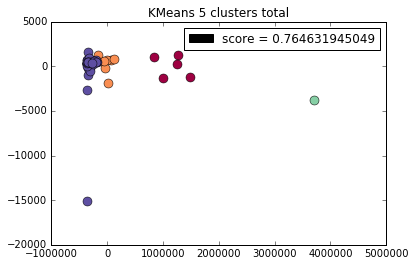

In [3]:
resellers_df = X[['reseller_id', 'reseller_volume', 'reseller_discount', 'amount_in_usd', 'customer_id']]
clusters_labels = list(clients_df['label'].unique())
clients_labels = clients_df[['customer_id', 'label']]
clients_labels.columns = ['customer_id', 'client_label']
resellers_grouped_df_mean = resellers_df.groupby('reseller_id').mean().reset_index()
resellers_df = pd.merge(resellers_df, clients_labels, on='customer_id')
resellers_df = data_preprocess.preprocess_categorical(resellers_df, ['client_label'])

clients_labels_full = list(filter(lambda x: 'client_label' in x, resellers_df.columns))
resellers_grouped_df_sum = resellers_df[['reseller_id', 'amount_in_usd'] + clients_labels_full].groupby(
    'reseller_id').sum().reset_index()
resellers_grouped_df = pd.merge(resellers_grouped_df_mean, resellers_grouped_df_sum, on='reseller_id')

resellers_grouped_clean_df = remove_columns(resellers_grouped_df, ['reseller_id', 'customer_id'])
n_clusters = 5
# f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
# cluster_reseller_model = ClusterizationModel(model="agglomerative").fit(resellers_grouped_clean_df)
# cluster_reseller_model.draw_clusters(method="", axis=ax1, show=False)
# cluster_reseller_model = ClusterizationModel(model="dbscan", eps=5e4, min_samples=1).fit(resellers_grouped_clean_df)
# cluster_reseller_model.draw_clusters(method="", axis=ax2, show=False)
cluster_reseller_model = ClusterizationModel(n_clusters=n_clusters, model="KMeans").fit(resellers_grouped_clean_df)
cluster_reseller_model.draw_clusters(method="", show=True)
# cluster_reseller_model = ClusterizationModel(model="hierarchy").fit(resellers_grouped_clean_df)
# cluster_reseller_model.draw_clusters(method="dendrogram", show=True)

In [4]:
print(cluster_reseller_model.get_mean_values())

       reseller_volume  reseller_discount  amount_in_usd_x  amount_in_usd_y  \
label                                                                         
0          1225.000000          11.000000       983.852343     1.533865e+06   
1           466.125000           8.125000      2220.811954     3.408392e+05   
2             1.000000           5.000000      1070.506278     4.929681e+06   
3          6238.000000          15.000000      1048.664231     4.062525e+06   
4           626.818182           7.386364      1920.696082     4.378037e+04   

       client_label  client_label_0  client_label_1  client_label_2  \
label                                                                 
0       1485.200000      525.000000      667.400000      408.600000   
1        175.000000       94.250000       93.500000       40.750000   
2       4136.000000     1730.000000     1614.000000     1261.000000   
3       3901.000000     1220.000000     1407.000000     1247.000000   
4         27.295455 

In [5]:
print(resellers_grouped_clean_df.corr())

                   reseller_volume  reseller_discount  amount_in_usd_x  \
reseller_volume           1.000000           0.262659        -0.073670   
reseller_discount         0.262659           1.000000         0.089119   
amount_in_usd_x          -0.073670           0.089119         1.000000   
amount_in_usd_y           0.182734           0.117305        -0.141062   
client_label              0.206764           0.169211        -0.165275   
client_label_0            0.171182           0.143049        -0.162125   
client_label_1            0.209703           0.230070        -0.171823   
client_label_2            0.197574           0.122773        -0.155094   
client_label_3            0.017817          -0.065639        -0.058729   
label                    -0.038333          -0.143722         0.072082   

                   amount_in_usd_y  client_label  client_label_0  \
reseller_volume           0.182734      0.206764        0.171182   
reseller_discount         0.117305      0.169211 

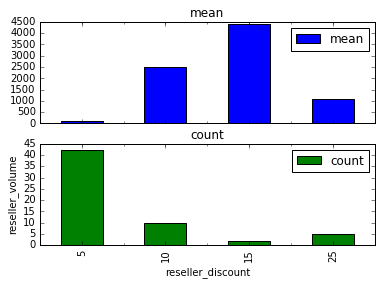

In [6]:
# plot resellers volume, grouped by discount
discount_groups = resellers_grouped_df[['reseller_volume', 'reseller_discount']].groupby('reseller_discount').agg(
    ['mean', 'count'])
discount_groups['reseller_volume'].plot(kind='bar', subplots=True)
plt.ylabel('reseller_volume')
plt.show()

In [7]:
resellers_grouped_df['reseller_cluster'] = pd.Series(cluster_reseller_model.get_labels())
X = pd.merge(X, resellers_grouped_df[['reseller_id', 'reseller_cluster'] + clients_labels_full], how='left',
             on='reseller_id')
X = data_preprocess.preprocess_categorical(X, ['reseller_cluster'])

X = X.set_index(X['placed_date'])
X = X.sort_index()

stock_ids = list(filter(lambda stock_id: metadata.stock_ids[stock_id][0] != 'None', X["stock_id"].unique()))
stock_ids = list(filter(lambda stock_id: len(X[X["stock_id"] == stock_id]) >= 10, stock_ids))

short_names = {v: k for k, v in metadata.stock_short_name_ids.items()}
stock_names = list(map(lambda st_id: metadata.stock_ids[st_id][0], stock_ids))

stocks_mse = []
stocks_accuracy = []
stocks_acc_confidence_intervals = []

stock_rows = X

techs = metadata.tech_ids.values()

predictors = get_columns(X, ['discount_desc', 'customer_status', 'license_type', 'reseller_discount',
                             'reseller_volume', 'urban', 'population', 'HDI', 'avg_income', 'GDP', 'client_label',
                             'reseller_cluster'])
# leave only derivative features: 'license_type_0', 'license_type_1' etc.
predictors.remove('license_type')
predictors.remove('reseller_cluster')

x = stock_rows[predictors]
from math import ceil

mean_quantity = ceil(stock_rows['quantity'].mean())
print("mean: %s" % mean_quantity)


def quantity_mapper(quantity):
    if quantity <= 1.1:
        return 0
    if quantity <= mean_quantity + 0.1:
        return 1
    return 2


response = "QuantityClass"
stock_rows[response] = stock_rows['quantity'].apply(quantity_mapper)

y = stock_rows[response]


def remove_if_constant(df, column):
    if df[column].isin(df[column].iloc[:1]).all():
        del df[column]


for column in x.columns:
    remove_if_constant(x, column)

folds_cnt = 10
if len(x) < 20:
    folds_cnt = 2
model = tree.DecisionTreeRegressor(max_features=10, random_state=0, max_depth=3,
                                     max_leaf_nodes=5)
# model = ensemble.GradientBoostingRegressor()
predicted = cross_val_predict(model, x, y, cv=folds_cnt, n_jobs=4)

predicted = predicted.round()

scores = cross_validation.cross_val_score(model, x, y, cv=folds_cnt, n_jobs=4)
model = model.fit(x, y)

# draw tree
from sklearn.externals.six import StringIO
import pydot

from IPython.display import Image
f = open("tree.dot", "w")
tree.export_graphviz(model, out_file=f,
                     feature_names=predictors)
f.close()
# graph = pydot.graph_from_dot_data(dot_data.getvalue())
# Image(graph.create_png())

mean: 4.0


In [8]:
feature_importances = sorted(zip(model.feature_importances_, predictors), reverse=True)
print("\n".join(map(lambda x: "%17s: %s" % (x[1], str(x[0])), (filter(lambda x: x[0] > 0, feature_importances)))))

customer_status_2: 0.710413408003
   license_type_0: 0.166432616933
reseller_discount: 0.0632792580193
  reseller_volume: 0.0598747170447


In [9]:
print("r2: %s" % scores.mean())

r2: 0.0691142139023


In [10]:
mse = metrics.mean_squared_error(y, predicted)
stocks_mse.append(mse)
print("mse: %s " % mse)

mse: 0.717070947486 


In [11]:
# residuals_df = pd.DataFrame([])
# residuals_df["value"] = abs(y - predicted)
# residuals_df = residuals_df.sort_values(by='value')
# plot_statistic(residuals_df["value"], "Residuals")

In [12]:
# pd.tools.plotting.scatter_matrix(clients, alpha=0.2,
#                                  c='red', hist_kwds={'color': ['burlywood']})
# plt.show()

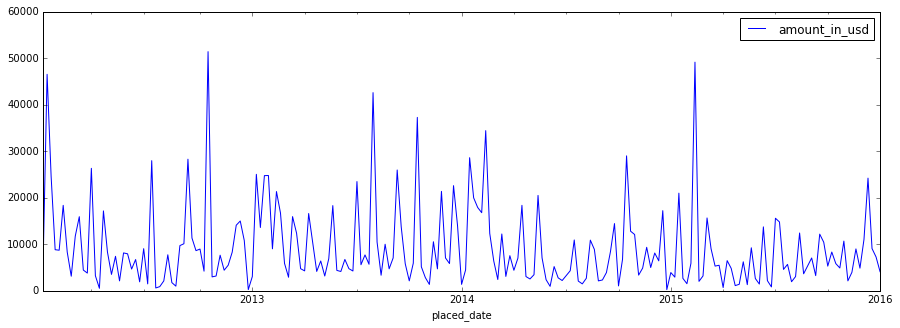

In [13]:
import statsmodels.api as sm
from scipy import stats
reseller_clusters = list(X['reseller_cluster'].unique())
cluster = reseller_clusters[2]
resellers_df = X[['reseller_cluster', 'amount_in_usd', 'placed_date']][X['reseller_cluster'] == cluster]
resellers_df['placed_date'] = pd.to_datetime(resellers_df['placed_date'])
resellers_df = resellers_df[(resellers_df['placed_date'] >= '2012-01-01') & (resellers_df['placed_date'] < '2016-01-01')]
resellers_df = resellers_df.set_index(resellers_df['placed_date'])
resellers_df = resellers_df.sort_index()
resellers_df = resellers_df[['amount_in_usd']]
resellers_df = resellers_df.groupby(pd.TimeGrouper(freq='W')).sum()
# resellers_df.loc[pd.to_datetime('2014-12-31')] = float(np.nan)
# resellers_df.loc[pd.to_datetime('2015-12-31')] = float(np.nan)
resellers_df['amount_in_usd'].interpolate(method="values", inplace=True)
time_series_df = pd.DataFrame(resellers_df[['amount_in_usd']])
time_series_df.plot(figsize=(15,5))
plt.show()

In [14]:
import pyflux as pf

In [ ]:
def estimate_garch(time_series_df):
    import sys
    def run_garch(garch):
        old_stdout = sys.stdout
        sys.stdout = mystdout = StringIO()
        garch.fit()
        sys.stdout = old_stdout
        arr = mystdout.getvalue().split('\n')
        Likelihood = AIC = BIC = None
        for s in arr:
            if "Log" in s:
                Likelihood = float(s.split(':')[1])
            if "AIC" in s:
                AIC = float(s.split(':')[1])
            if "BIC" in s:
                BIC = float(s.split(':')[1])
        return Likelihood, AIC, BIC

    best = {'AIC': 99999,
            'BIC': 99999,
            'Log':-99999,
            'GARCH': None
           }
    for p in range(1,20,2):
        for q in range(2,25,2):
            if p == q+1:
                print("%s %s" % (p,q))
                garch = pf.EGARCH(time_series_df,p=p,q=q)
                l, aic, bic = run_garch(garch)
                if l > best["Log"]:
                    best["AIC"] = aic
                    best["BIC"] = bic
                    best["Log"] = l
                    best["GARCH"] = garch
    best['GARCH'].plot_fit(figsize=(15,5))

amount_in_usd picked as target variable

Hessian not invertible! Consider a different model specification.

EGARCH(20,19)
Method: MLE
Number of observations: 189
Log Likelihood: -2048.826
AIC: 4179.652
BIC: 4312.5636

Parameter                                Estimate  
======================================== ==========
Constant                                 18.9291   
p(1)                                     -0.55     
p(2)                                     -0.3445   
p(3)                                     -0.0559   
p(4)                                     0.0736    
p(5)                                     0.0679    
p(6)                                     -0.152    
p(7)                                     0.0744    
p(8)                                     0.2888    
p(9)                                     0.0864    
p(10)                                    -0.1908   
p(11)                                    -0.5359   
p(12)                                    -0.2936   
p(

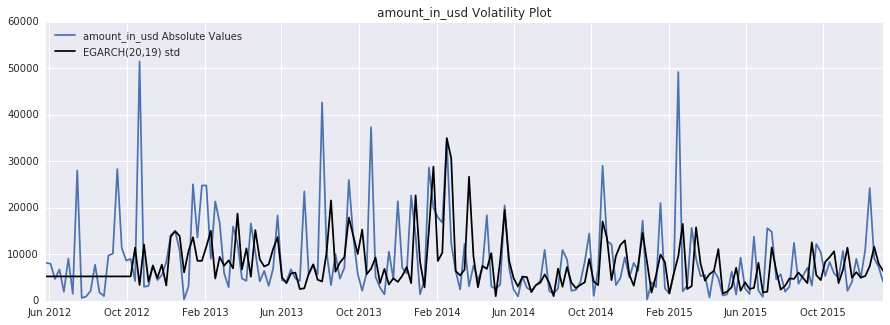

In [33]:
garch = pf.EGARCH(time_series_df,p=20,q=19)
garch.fit()
garch.plot_fit(figsize=(15,5))

/home/semionn/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:740: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
/home/semionn/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1001: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
/home/semionn/anaconda2/lib/python2.7/site-packages/numdifftools/core.py:520: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))


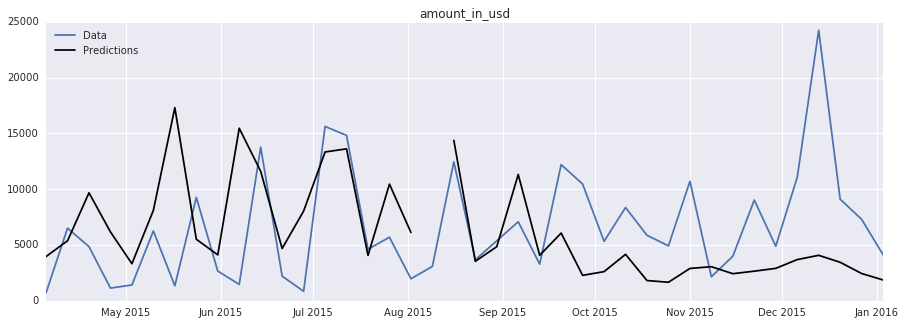

In [34]:
garch.plot_predict_is(h=40,figsize=(15,5))

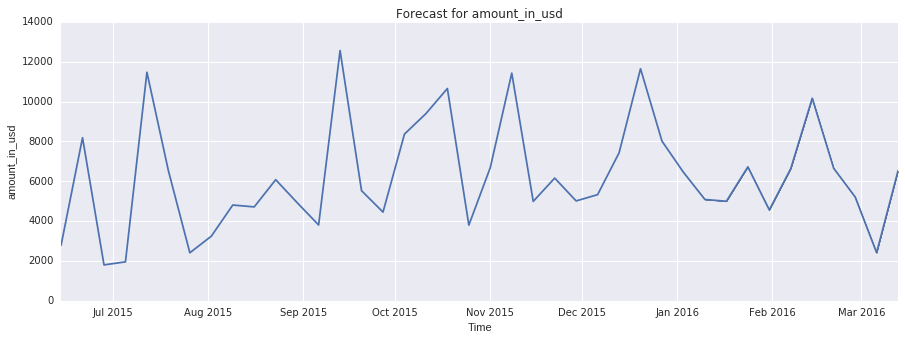

             amount_in_usd
placed_date               
2016-01-10     5083.606803
2016-01-17     4994.828128
2016-01-24     6720.885790
2016-01-31     4559.303187
2016-02-07     6636.159066
2016-02-14    10165.808826
2016-02-21     6648.146361
2016-02-28     5210.180014
2016-03-06     2413.773446
2016-03-13     6533.311522


In [35]:
garch.plot_predict(h=10,past_values=30,figsize=(15,5))
print(garch.predict(h=10))